In [4]:
import numpy as np

from helpers import load_csv_data
from ml_methods.implementations import logistic_regression, sigmoid, reg_logistic_regression, calculate_loss
from ml_methods.implementations import ridge_regression, least_squares_SGD
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import StandardScaler
import scipy

np.random.seed(10)

In [5]:
y, x, ids = load_csv_data('./data/train.csv')

# Data Processing and feature engineering

In [6]:
def scaler(x, m=0, std=0, train=True):
    if train:
        m = np.mean(x, axis=0)
        std = np.std(x, axis=0)
    x = (x - m) / std
    return x, m, std

def shuffle_split_data(x, y, scale=0.9):
    perc = scale * 100
    arr_rand = np.random.rand(x.shape[0])
    split = arr_rand < np.percentile(arr_rand, perc)

    x_train = x[split]
    y_train = y[split]
    x_test =  x[~split]
    y_test = y[~split]
    return x_train, y_train, x_test, y_test

In [7]:
def process_data(x, y, poly=False, cv=3):
    splits = []
    x = np.delete(x, [5, 6, 12, 26, 27, 28, 29, 25], axis=1)
    x[:,0][x[:,0] == -999] = -5
    x[:,20][x[:,20] == -999] = -5
    
    for k in range(cv):  
        x_train, y_train, x_test, y_test = shuffle_split_data(x, y, 0.9)

        if poly:
            x_train = np.concatenate([x_train, x_train**2], axis=1)
            x_test = np.concatenate([x_test, x_test**2], axis=1)

        x_train, m_train, std_train = scaler(x_train, train=True)

        x_test, _, _ = scaler(x_test, m=m_train, std=std_train, train=False)

        x_train = np.hstack((x_train, np.ones((len(x_train), 1))))
        x_test = np.hstack((x_test, np.ones((len(x_test), 1))))

        splits.append((x_train, y_train, x_test, y_test))
    return splits

# Model selection

## Baseline: logistic regression

In [29]:
n_epochs = 1000

In [30]:
from tqdm import trange

splits_1 = process_data(x, y, poly=False, cv=3)

In [31]:
weights_1 = []
train_losses_1 = []
test_losses_1 = []
for split in splits_1:
    x_train, y_train, x_test, y_test = split
    w_init = np.random.normal(0, 1, size=(x_train.shape[1],)) 
    w = w_init
    train_losses = []
    test_losses = []
    for epoch in trange(n_epochs):
        w, loss = logistic_regression(y_train, x_train, w, 1, 0.05)
        train_losses.append(calculate_loss(y_train, x_train, w))
        test_losses.append(calculate_loss(y_test, x_test, w))
    weights_1.append(w)
    train_losses_1.append(train_losses)
    test_losses_1.append(test_losses)

100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.94it/s]


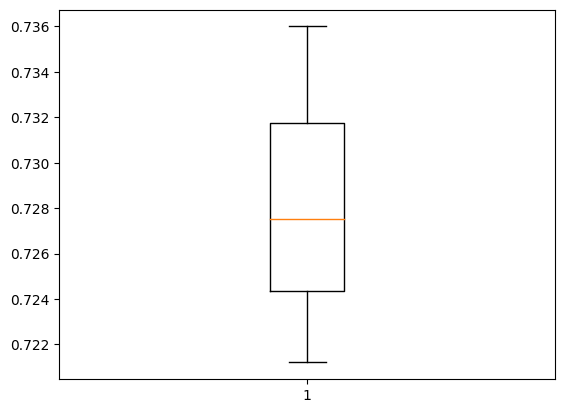

In [32]:
from sklearn.metrics import accuracy_score, f1_score

metrics_1 = {'acc': [], 'f1': []}
for k, split in enumerate(splits_1):
    w = weights_1[k]
    x_train, y_train, x_test, y_test = split
    pred_val = sigmoid(x_test @ w)

    val_acc = accuracy_score(pred_val > 0.5, y_test)
    val_f1 = f1_score(pred_val > 0.5, y_test)
    metrics_1['acc'].append(val_acc)
    metrics_1['f1'].append(val_f1)
plt.boxplot(metrics_1['acc'])
plt.show()

## Logistic regression + LR scheduling

In [33]:
def gamma(epoch, n_epochs):
    gamma_max = 0.05
    gamma_min = 0.001
    gamma = (gamma_max - gamma_min) / n_epochs * epoch + gamma_max
    return gamma



weights_2 = []
train_losses_2 = []
test_losses_2 = []
for split in splits_1:
    x_train, y_train, x_test, y_test = split
    w_init = np.random.normal(0, 1, size=(x_train.shape[1],)) 
    w = w_init
    train_losses = []
    test_losses = []
    for epoch in trange(n_epochs):
        w, loss = logistic_regression(y_train, x_train, w, 1, gamma(epoch, n_epochs))
        train_losses.append(calculate_loss(y_train, x_train, w))
        test_losses.append(calculate_loss(y_test, x_test, w))
    weights_2.append(w)
    train_losses_2.append(train_losses)
    test_losses_2.append(test_losses)

  4%|█▋                                       | 41/1000 [00:00<00:17, 53.39it/s]/home/mike/ML2022/ml-project-1-grandmasters/project1/ml_methods/implementations.py:93: RuntimeWarning: divide by zero encountered in log
  loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
/home/mike/ML2022/ml-project-1-grandmasters/project1/ml_methods/implementations.py:93: RuntimeWarning: invalid value encountered in multiply
  loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 52.21it/s]


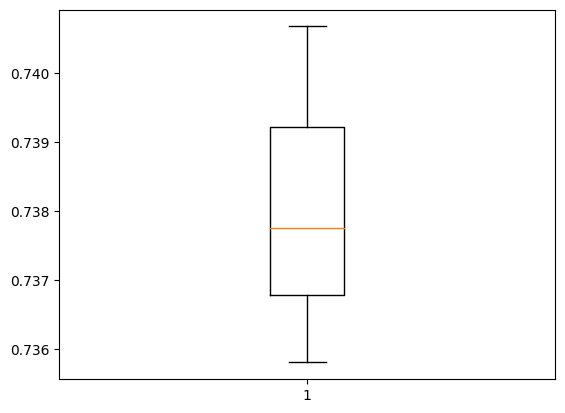

In [34]:
metrics_2 = {'acc': [], 'f1': []}
for k, split in enumerate(splits_1):
    w = weights_2[k]
    x_train, y_train, x_test, y_test = split
    pred_val = sigmoid(x_test @ w)

    val_acc = accuracy_score(pred_val > 0.5, y_test)
    val_f1 = f1_score(pred_val > 0.5, y_test)
    metrics_2['acc'].append(val_acc)
    metrics_2['f1'].append(val_f1)
plt.boxplot(metrics_2['acc'])
plt.show()

## Logistic regression + regularization

In [35]:
ls = [0.001, 0.01, 0.1, 1]

weights_3 = {l : [] for l in ls}
train_losses_3 = {l : [] for l in ls}
test_losses_3 = {l : [] for l in ls}
metrics_3 = {l:{'acc': [], 'f1': []} for l in ls}
for l in ls:
        
    for split in splits_1:
        x_train, y_train, x_test, y_test = split
        w_init = np.random.normal(0, 1, size=(x_train.shape[1],)) 
        w = w_init
        train_losses = []
        test_losses = []
        for epoch in trange(n_epochs):
            w, loss = reg_logistic_regression(y_train, x_train, l, w, 1, 0.05)
            train_losses.append(calculate_loss(y_train, x_train, w))
            test_losses.append(calculate_loss(y_test, x_test, w))
        weights_3[l].append(w)
        train_losses_3[l].append(train_losses)
        test_losses_3[l].append(test_losses)
    
        # predict on test
        pred_val = sigmoid(x_test @ w)

        val_acc = accuracy_score(pred_val > 0.5, y_test)
        val_f1 = f1_score(pred_val > 0.5, y_test)
        metrics_3[l]['acc'].append(val_acc)
        metrics_3[l]['f1'].append(val_f1)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/home/mike/ML2022/ml-project-1-grandmasters/project1/ml_methods/implementations.py:93: RuntimeWarning: divide by zero encountered in log
  loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
/home/mike/ML2022/ml-project-1-grandmasters/project1/ml_methods/implementations.py:93: RuntimeWarning: invalid value encountered in multiply
  loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
  0%|                                                  | 0/1000 [00:00<?, ?it/s]/home/mike/ML2022/ml-project-1-grandmasters/project1/ml_methods/implementations.py:93: RuntimeWarning: divide by zero encountered in log
  loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
/home/mike/ML2022/ml-project-1-grandmasters/project1/ml_methods/implementations.py:93: RuntimeWarning: invalid value encountered in multiply
  loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
  0%|                                       

In [36]:
for k, v in metrics_3.items():
    print(k, np.mean(v['acc']))

0.001 0.7285866666666667
0.01 0.7319466666666666
0.1 0.7142400000000001
1 0.6869466666666666


## Polynomial features

In [37]:
splits_2 = process_data(x, y, poly=True, cv=3)

In [38]:
weights_4 = []
train_losses_4 = []
test_losses_4 = []
for split in splits_2:
    x_train, y_train, x_test, y_test = split
    w_init = np.random.normal(0, 1, size=(x_train.shape[1],)) 
    w = w_init
    train_losses = []
    test_losses = []
    for epoch in trange(n_epochs):
        w, loss = logistic_regression(y_train, x_train, w, 1, 0.05)
        train_losses.append(calculate_loss(y_train, x_train, w))
        test_losses.append(calculate_loss(y_test, x_test, w))
    weights_4.append(w)
    train_losses_4.append(train_losses)
    test_losses_4.append(test_losses)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/home/mike/ML2022/ml-project-1-grandmasters/project1/ml_methods/implementations.py:93: RuntimeWarning: divide by zero encountered in log
  loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
/home/mike/ML2022/ml-project-1-grandmasters/project1/ml_methods/implementations.py:93: RuntimeWarning: invalid value encountered in multiply
  loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
  0%|                                                  | 0/1000 [00:00<?, ?it/s]/home/mike/ML2022/ml-project-1-grandmasters/project1/ml_methods/implementations.py:85: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-t))
100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 31.17it/s]


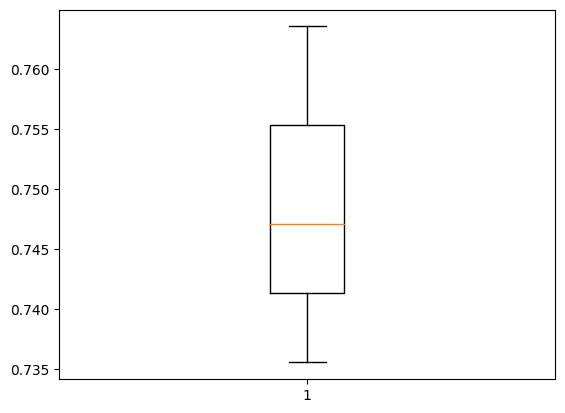

In [39]:
metrics_4 = {'acc': [], 'f1': []}
for k, split in enumerate(splits_2):
    w = weights_4[k]
    x_train, y_train, x_test, y_test = split
    pred_val = sigmoid(x_test @ w)

    val_acc = accuracy_score(pred_val > 0.5, y_test)
    val_f1 = f1_score(pred_val > 0.5, y_test)
    metrics_4['acc'].append(val_acc)
    metrics_4['f1'].append(val_f1)
plt.boxplot(metrics_4['acc'])
plt.show()

## Polynomial features + reg

In [70]:
# ls = [0.001, 0.01, 0.1, 1]
ls = [0.01]

weights_5 = {l : [] for l in ls}
train_losses_5 = {l : [] for l in ls}
test_losses_5 = {l : [] for l in ls}
metrics_5 = {l:{'acc': [], 'f1': []} for l in ls}
for l in ls:
        
    for split in splits_2:
        x_train, y_train, x_test, y_test = split
        w_init = np.random.normal(0, 1, size=(x_train.shape[1],)) 
        w = w_init
        train_losses = []
        test_losses = []
        for epoch in trange(n_epochs):
            w, loss = reg_logistic_regression(y_train, x_train, l, w, 1, gamma(epoch, n_epochs))
            train_losses.append(calculate_loss(y_train, x_train, w))
            test_losses.append(calculate_loss(y_test, x_test, w))
        weights_5[l].append(w)
        train_losses_5[l].append(train_losses)
        test_losses_5[l].append(test_losses)
    
        # predict on test
        pred_val = sigmoid(x_test @ w)

        val_acc = accuracy_score(pred_val > 0.5, y_test)
        val_f1 = f1_score(pred_val > 0.5, y_test)
        metrics_5[l]['acc'].append(val_acc)
        metrics_5[l]['f1'].append(val_f1)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/home/mike/ML2022/ml-project-1-grandmasters/project1/ml_methods/implementations.py:93: RuntimeWarning: divide by zero encountered in log
  loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
/home/mike/ML2022/ml-project-1-grandmasters/project1/ml_methods/implementations.py:93: RuntimeWarning: invalid value encountered in multiply
  loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
  0%|                                                  | 0/1000 [00:00<?, ?it/s]/home/mike/ML2022/ml-project-1-grandmasters/project1/ml_methods/implementations.py:93: RuntimeWarning: divide by zero encountered in log
  loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
/home/mike/ML2022/ml-project-1-grandmasters/project1/ml_methods/implementations.py:93: RuntimeWarning: invalid value encountered in multiply
  loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
  0%|                                       

In [71]:
for k, v in metrics_3.items():
    print(k, np.mean(v['acc']))

0.001 0.7285866666666667
0.01 0.7319466666666666
0.1 0.7142400000000001
1 0.6869466666666666


In [48]:
#submissions creating
from helpers import create_csv_submission

def process_data(x, y, x_test, y_test):
    x = np.delete(x, [5, 6, 12, 26, 27, 28, 29, 25], axis=1)
    x[:,0][x[:,0] == -999] = -5
    x[:,20][x[:,20] == -999] = -5
    
    x_test = np.delete(x_test, [5, 6, 12, 26, 27, 28, 29, 25], axis=1)
    x_test[:,0][x_test[:,0] == -999] = -5
    x_test[:,20][x_test[:,20] == -999] = -5

    x = np.concatenate([x, x**2], axis=1)
    x_test = np.concatenate([x_test, x_test**2], axis=1)

    x, m_train, std_train = scaler(x, train=True)

    x_test, _, _ = scaler(x_test, m=m_train, std=std_train, train=False)

    x = np.hstack((x, np.ones((len(x), 1))))
    x_test = np.hstack((x_test, np.ones((len(x_test), 1))))

    return x, y, x_test, y_test

# submission run
y_test, x_test, ids_test = load_csv_data('./data/test.csv')
x_train, y_train, x_test, y_test = process_data(x, y, x_test, y_test)
w_init = np.random.normal(0, 1, size=(x_train.shape[1],)) 
w, loss = reg_logistic_regression(y_train, x_train, 0.01, w_init, 1000, 0.05)

pred_val = sigmoid(x_test @ w)

predictions = np.where(pred_val > 0.5, 1, -1)

create_csv_submission(ids_test, predictions, "final.csv")

/home/mike/ML2022/ml-project-1-grandmasters/project1/ml_methods/implementations.py:93: RuntimeWarning: divide by zero encountered in log
  loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
/home/mike/ML2022/ml-project-1-grandmasters/project1/ml_methods/implementations.py:93: RuntimeWarning: invalid value encountered in multiply
  loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))


# Boxplots for report

In [55]:
data = [metrics_1['acc'], metrics_2['acc'], metrics_3[0.01]['acc'], metrics_4['acc'], metrics_5[0.01]['acc']]

/tmp/ipykernel_6269/2008141736.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0', '1', '2', '3', '4', '5'])
/home/mike/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


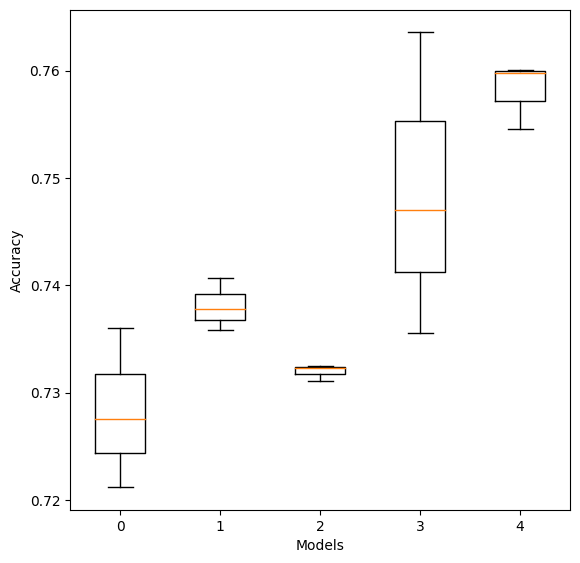

In [63]:
fig = plt.figure(figsize =(5, 5))
ax = fig.add_axes([0, 0, 1, 1])


ax.set_xticklabels(['0', '1', '2', '3', '4', '5'])
# ax.set_xticklabels(['baseline on processed features', 'LR-scheduling',
#                     'regularization with term 0.01', 'squared features', 'squared features and regularization with term 0.01'])

# ax.legend(data[0], data[1], ['A', 'B'], loc='upper right')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')

bp = ax.boxplot(data)
 
# show plot
plt.show()

In [69]:
print(np.mean(data, axis=1), "+-\n", np.std(data, axis=1))


[0.72824    0.73808    0.73194667 0.74870667 0.75814667] +-
 [0.00606349 0.00200506 0.00061478 0.01150779 0.00253873]
